**Tomasz Stolarczyk, 333090 - HW6**


#### **Analiza jednej z podstwowych końcówek gry w szachy**
---

**Zacznijmy od Przygotowania Danych:**

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# zaciągamy dane
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/chess/king-rook-vs-king/krkopt.data"
cols = ['wk_f', 'wk_r', 'wr_f', 'wr_r', 'bk_f', 'bk_r', 'result']
df = pd.read_csv(url, names=cols)

df.head()


,wk_f,wk_r,wr_f,wr_r,bk_f,bk_r,result
0,a,1,b,3,c,2,draw
1,a,1,c,1,c,2,draw
2,a,1,c,1,d,1,draw
3,a,1,c,1,d,2,draw
4,a,1,c,2,c,1,draw


In [8]:
# mapujemy litery na liczby
f_map = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8}
for c in ['wk_f', 'wr_f', 'bk_f']: df[c] = df[c].map(f_map)

df.head()

,wk_f,wk_r,wr_f,wr_r,bk_f,bk_r,result
0,1,1,2,3,3,2,draw
1,1,1,3,1,3,2,draw
2,1,1,3,1,4,1,draw
3,1,1,3,1,4,2,draw
4,1,1,3,2,3,1,draw


In [9]:
# mapujemy wynikowy string na liczbę oznaczającą głębokość do mata
res_map = {'draw': -1, 'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 
           'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10, 'eleven': 11, 
           'twelve': 12, 'thirteen': 13, 'fourteen': 14, 'fifteen': 15, 'sixteen': 16}
df['depth'] = df['result'].map(res_map)

df.head()

,wk_f,wk_r,wr_f,wr_r,bk_f,bk_r,result,depth
0,1,1,2,3,3,2,draw,-1
1,1,1,3,1,3,2,draw,-1
2,1,1,3,1,4,1,draw,-1
3,1,1,3,1,4,2,draw,-1
4,1,1,3,2,3,1,draw,-1


In [10]:
# dodatkowe kolumny potrzebne do analizy
df['dist_eucl'] = np.sqrt((df.wk_f - df.bk_f)**2 + (df.wk_r - df.bk_r)**2)
df['dist_manh'] = np.abs(df.wk_f - df.bk_f) + np.abs(df.wk_r - df.bk_r)
df['dist_cheb'] = np.maximum(np.abs(df.wk_f - df.bk_f), np.abs(df.wk_r - df.bk_r))
df['edge_dist'] = df[['bk_f', 'bk_r']].apply(lambda x: min(x[0]-1, 8-x[0], x[1]-1, 8-x[1]), axis=1)

df.head()

C:\Users\Tomas\AppData\Local\Temp\ipykernel_2224\87777091.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['edge_dist'] = df[['bk_f', 'bk_r']].apply(lambda x: min(x[0]-1, 8-x[0], x[1]-1, 8-x[1]), axis=1)


,wk_f,wk_r,wr_f,wr_r,bk_f,bk_r,result,depth,dist_eucl,dist_manh,dist_cheb,edge_dist
0,1,1,2,3,3,2,draw,-1,2.236068,3,2,1
1,1,1,3,1,3,2,draw,-1,2.236068,3,2,1
2,1,1,3,1,4,1,draw,-1,3.000000,3,3,0
3,1,1,3,1,4,2,draw,-1,3.162278,4,3,1
4,1,1,3,2,3,1,draw,-1,2.000000,2,2,0


### **Pytanie 1**
*Gdzie zwykle znajduje się na planszy czarny król, kiedy jest matowany (white-depth-of-win=0)? Gdzie znajduje się, kiedy gra kończy się remisem (white-depth-of-win=-1)?*

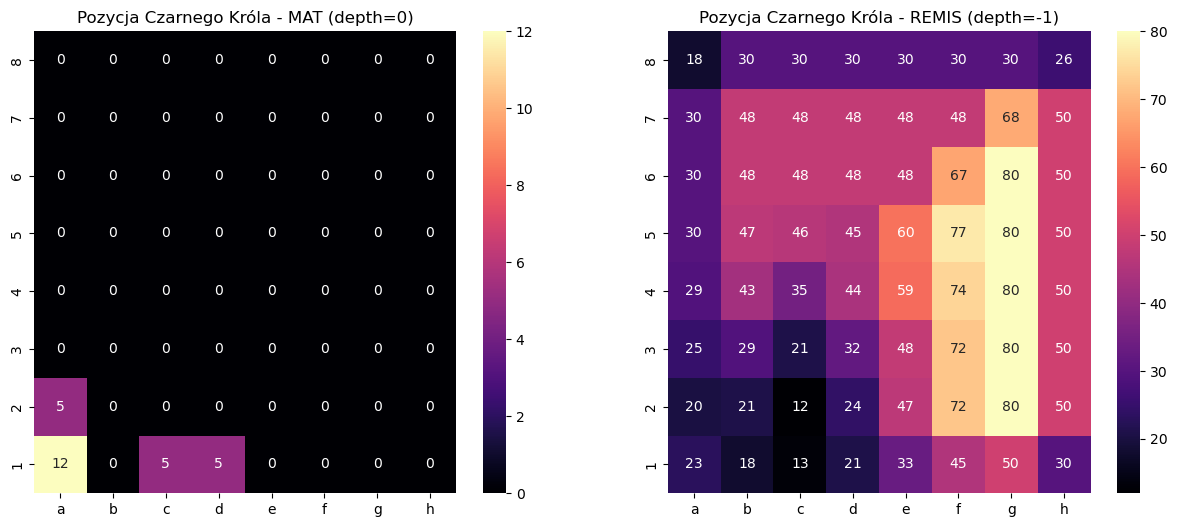

In [ ]:
# tworzymy heatmapki
def plot_heat(data, title, ax):
    h_data = np.zeros((8, 8))
    for _, r in data.iterrows(): h_data[int(r.bk_r)-1, int(r.bk_f)-1] += 1
    sns.heatmap(h_data, annot=True, fmt='g', cmap='magma', ax=ax,
                xticklabels=['a','b','c','d','e','f','g','h'], yticklabels=range(1,9))
    ax.invert_yaxis()
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_heat(df[df.depth == 0], "Pozycja Czarnego Króla - MAT (depth=0)", axes[0])
plot_heat(df[df.depth == -1], "Pozycja Czarnego Króla - REMIS (depth=-1)", axes[1])
plt.show()

**Sytuacji matowa** (depth=0)
Zamatowanie samotnego króla przy użyciu samej wieży i króla jest możliwe **wyłącznie** na **krawędzi planszy** lub w jej **rogu**.

**Sytuacja patowa** (depth=-1)
W przypadku remisów rozkład pozycji czarnego króla jest **znacznie bardziej rozproszony**, choć również występują częściej w pobliżu krawędzi.

### **Pytanie 2**
*Jednym z istotnych czynników tego, w ilu ruchach gra się zakończy jest dystans pomiędzy białym królem a czarnym królem. Jaka metryka dystansu (Euklidesowa, Manhattan, lub Czebyszewa) pomiędzy nimi pozwoli najlepiej oszacować liczbę ruchów do zakończenia gry? Do tej analizy zignorujmy sytuacje remisowe (white-depth-of-win = -1).*

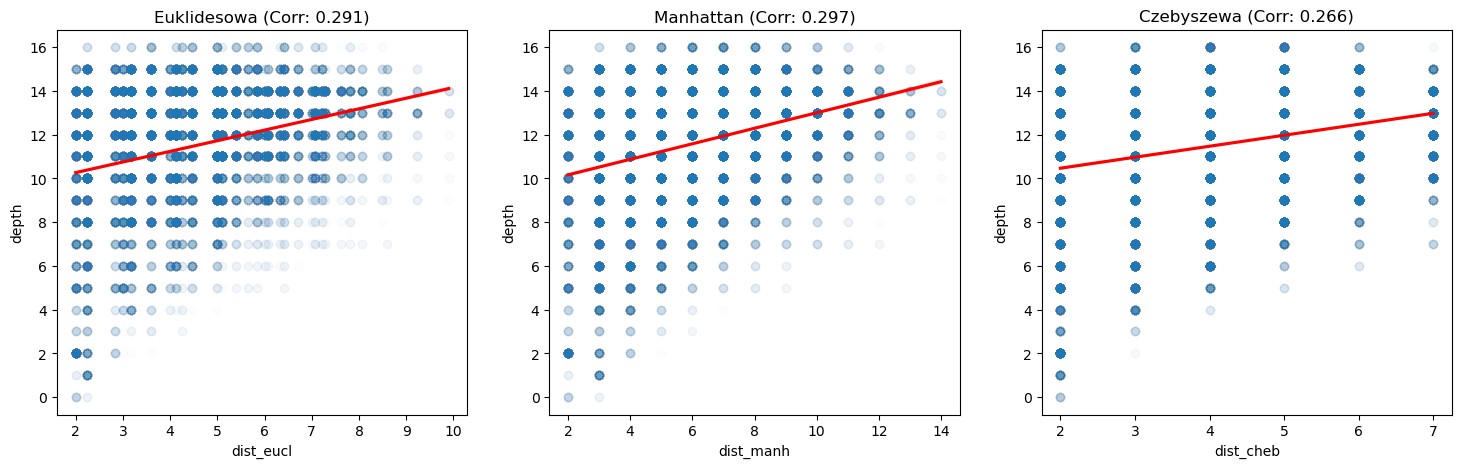

In [12]:
# badamy jak dobre są metryki do przewidywania głębokości do mata
df_win = df[df.depth != -1]
metrics = ['dist_eucl', 'dist_manh', 'dist_cheb']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, m, t in zip(axes, metrics, ['Euklidesowa', 'Manhattan', 'Czebyszewa']):
    sns.regplot(data=df_win, x=m, y='depth', ax=ax, scatter_kws={'alpha':0.01}, line_kws={'color':'red'})
    ax.set_title(f"{t} (Corr: {df_win[m].corr(df_win.depth):.3f})")
plt.show()

Wyniki dla wszystkich 3 metryk są bardzo zbliżone, ale najlepszą  okauzję się metryka **Manhattan** (najwyższy współczynnik korelacji, wynoszący 0.297).

Intuicyjnie ma to sens - metryka Czebyszewa mierzy "najdłuższą drogę" (pion lub poziom). Ale w szachach, żeby zamatować króla, nie wystarczy tylko podejść do niego po skosie. Trzeba go ograniczyć i w pionie, i w poziomie - wieża "wycina" rzędy, a król "wycina" kolumny. Metryka Manhattan, która sumuje obie te odległości (|x| + |y|), lepiej oddaje ten sumaryczny wysiłek, jaki białe muszą włożyć w "osaczenie" przeciwnika.

### **Pytanie 3**
**podunkt a:**
*Czy informacja o odległości czarnego króla od krawędzi planszy może być przydatna w określeniu w ilu ruchach zakończy się gra?*

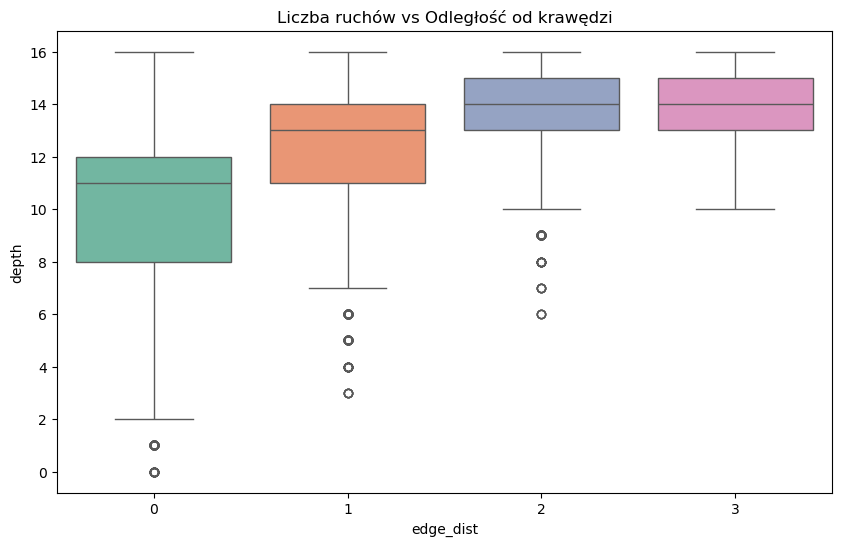

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_win, x='edge_dist', y='depth', palette='Set2', hue ='edge_dist', legend=None)
plt.title("Liczba ruchów vs Odległość od krawędzi")
plt.show()

Ewidentnie im bliżej krawędzi znajduje się czarny król, tym średnio w mniejszej liczbie ruchów gra się zakończy. 
Wynika to z faktu, że przy bandzie król ma drastycznie ograniczoną swobodę ruchu.

**podunkt b:**
*Czy uzupełnienie tej informacji o odległość pomiędzy białym a czarnym królem z poprzedniego zadania może dodatkowo pomóc? Do tej analizy zignorujmy sytuacje remisowe (white-depth-of-win = -1).*



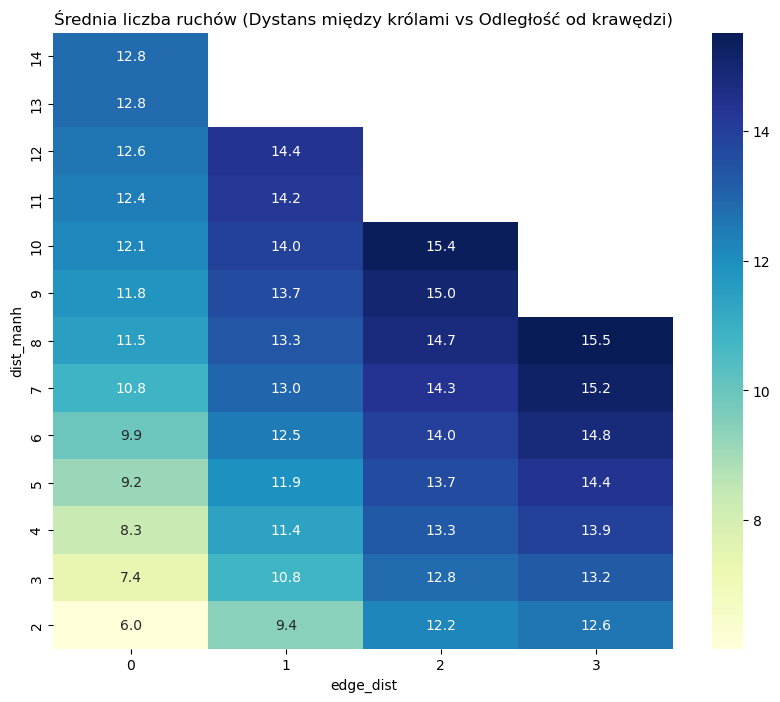

In [23]:
pivot = df_win.pivot_table(index='dist_manh', columns='edge_dist', values='depth', aggfunc='mean')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Średnia liczba ruchów (Dystans między królami vs Odległość od krawędzi)")
plt.gca().invert_yaxis()
plt.show()

Czy dodanie odległości między królami pomaga? 
**Zdecydowanie tak**.

Sama informacja o krawędzi to nie wszystko. Jak widać na heatmapie, nawet gdy czarny król jest na krawędzi, ale biały król jest daleko, liczba ruchów do mata znacznie wzrasta. Najszybsze wygrane (ok. 6-7 ruchów) wymagają współpracy obu tych czynników: czarnego króla na krawędzi oraz bliskiej obecności białego króla.

---
To wszystko na dziś.
**Dzięki za uwagę!**